In [1]:
# IMPORT
%matplotlib inline
import csv
import os
from operator import itemgetter, attrgetter, methodcaller
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import disk
from skimage.feature import match_template
from skimage.color import lab2rgb
from skimage.io import imread as sk_imread
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from scipy import ndimage

import ipywidgets as widgets
from IPython.display import Image
from IPython import display

# Imports the Google Cloud client library
from google.cloud import storage

In [8]:
# UTILITY func
cube_size = 250
bucket_name = "thesis-papyri"
imgs_root = "PAPYRI/" # "/Volumes/250GB/PAPYRI/"
cropped_root = "/cropped2/" # "/Volumes/250gb/cropped2"
matched_root = "/matched593/" # "/Volumes/250gb/cropped2"
local_temp_root = "/Users/il239838/Downloads/temp/"

# Instantiates a client
storage_client = storage.Client()

def list_blobs_with_prefix(prefix):
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter='/')

    for blob in blobs:
        if blob.name[-1] != '/':
            yield blob.name
        
    #     if delimiter:
    #         print('Prefixes:')
    #         for prefix in blobs.prefixes:
    #             print(prefix)

def download_blob(source_blob_name, destination_file_name):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))

def gcp_img_read(img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(img_path, local_temp_root + fname)
    result = img.imread(local_temp_root + fname)
    os.remove(local_temp_root + fname)
    return result

def gcp_np_load(img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(img_path, local_temp_root + fname)
    result = np.load(local_temp_root + fname)
    os.remove(local_temp_root + fname)
    return result
    
# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]


def calc_combined_coordinates(base_x, base_y, offset_x, offset_y, base_rotate, base_x_end):
    if base_rotate:
        result_x = base_x_end - cube_size - offset_y # 250==CUBE_SIZE
        result_y = base_y + offset_x
    else:
        result_x = base_x + offset_x
        result_y = base_y + offset_y
    return result_x, result_y

def load_img_for_name(file_name):
    img_path = ""
    if "-" in file_name:
        name_parts = file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-V/"
    
    for file_ in list_blobs_with_prefix(img_path):
        if (" _018" in file_):        
            return gcp_img_read(file_) # img.imread(img_path + file_)

def load_cropped_for_name(file_name):
    img_path = cropped_root + "/" + file_name + " _018.jpg.npy"
    return gcp_np_load(img_path) # np.load(img_path)

def load_front_for_name(file_name):
    img_path = ""
    if "-" in file_name:
        front_file_name = file_name.replace("-V-","-R-")
        name_parts = front_file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-R/"
    #import pdb; pdb.set_trace()
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(img_path):
        if (" _018" in file_):        
            return gcp_img_read(file_) # img.imread(img_path + file_)
    
# Pre-process the validation set
def folder_walker(path, full_path, filter_text=""):
    result = []
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(path):
        if "-V-" in file_ and not file_.startswith("."):
            if (filter_text == "" or filter_text in file_):
                result.append(file_)
    return result

no_rotate = folder_walker("/Volumes/250GB/no_rotate", False)

  

In [3]:
# UTIL 2
def find_match(big_img, small_img):
    match_map = match_template(big_img, small_img)
    offsets_arr = np.unravel_index(np.argmax(match_map), match_map.shape)
    offset_x, offset_y = offsets_arr[::-1]        
    return offset_x, offset_y, match_map[offsets_arr]
  

def extract_image_derivatives(file_name):
    image = load_img_for_name(file_name)
    split = file_name.split("-")
    short_name = split[0] + split[1]
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    # import pdb; pdb.set_trace()
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[:,::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr > val_ud):
        return cropped_flipped_lr.shape[1], offset_x_lr, offset_y_lr
    else:
        return cropped_flipped_ud.shape[1], offset_x_ud, offset_y_ud
    

def extract_image_derivatives_orig(file_name):
    image = load_img_for_name(file_name)
    split = file_name.split("-")
    short_name = split[0] + split[1]
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[:,::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr > val_ud):
        return front, cropped_flipped_lr, offset_x_lr, offset_y_lr
    else:
        return front, cropped_flipped_ud, offset_x_ud, offset_y_ud
    
    

x1start = 0
y1start = 0


def get_cube_coordinates(file_name, cropped_width, offset_x, offset_y, cubex, cubey):
    if file_name[0:file_name.rfind('-D')] not in no_rotate:
        temp = cubex
        cubex = cropped_width - cubey - cube_size
        cubey = temp

    reverse_cubex = x1start + offset_x + cube_size + (cropped_width - cubex - cube_size)
    reverse_cubey = y1start + offset_y + cube_size + cubey
    
    return reverse_cubex, reverse_cubey


def get_cropped(image, file_name):
    # import pdb; pdb.set_trace()
    short_name = file_name
    if "-" in file_name:
        short_name = file_name.split("-")
        short_name = short_name[0] + short_name[1]
    img_crop = crops[short_name]
    
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)

    return cropped
#     if file_name[0:file_name.rfind('-D')] not in no_rotate:
#         temp = cubex
#         cubex = cropped_width - cubey - cube_size
#         cubey = temp

#     reverse_cubex = x1start + offset_x + cube_size + (cropped_width - cubex - cube_size)
#     reverse_cubey = y1start + offset_y + cube_size + cubey
    
#     return reverse_cubex, reverse_cubey

In [4]:
# READ crops
crops = {}
with open('crops.csv') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=("file","x_start","y_start","x_end","y_end","rotate"))
    next(reader)
    for row in reader:
        row['name'] = row['file'].split("/")[5] # stay with the folder name
        row['name'] = row['name'].split("-")
        row['name'] = row['name'][0] + row['name'][1] # set the short name...
        row['x_start'] = int(row['x_start'])
        row['y_start'] = int(row['y_start'])
        row['x_end'] = int(row['x_end'])
        row['y_end'] = int(row['y_end'])
        # import pdb; pdb.set_trace()
        row['rotate'] = True if row['rotate'] == 'True' else False
        crops[row['name']] = row


In [5]:
# READ matches
matches = {}
with open('20181020_212330_pairs_final.csv') as csvfile: # cubes_X3
    reader = csv.DictReader(csvfile, fieldnames=("fragmentAndSide", 
                        "fragment", 
                        "fragmentTotal",
                        "fragmentVote",
                        "devideVoteByTotal",
                        "fragmentAndSideTotal",
                        "fragmentAndSideVote",
                        "devideSideVoteBySideTotal",
                        "fragmentAndSideTrendVote",
                        "devideSideTrendVoteBySideTotal",
                        "fragmentAndSideTrendVoteStrict",
                        "devideSideTrendVoteStrictBySideTotal",
                        "fragmentAndSideTrendVoteSync",
                        "devideSideTrendVoteSyncBySideTotal",
                        "firstFileName",
                        "firstCroppedWidth",
                        "firstOffsetX",
                        "firstOffsetY",
                        "firstHorizontalFlip",
                        "secondFileName",
                        "secondCroppedWidth",
                        "secondOffsetX",
                        "secondOffsetY",
                        "secondHorizontalFlip",
                        "fragmentAndSideTrend",
                        "fragmentAndSideCubes",
                        "fragmentAndSideDrawRect",
                        "fragmentAndSideMatchPoint",
                        "origCoordinates"))
    next(reader)
    for row in reader:
        matches[row["fragmentAndSide"]] = row

In [6]:
# RUN
loading = img.imread("loading.jpg", format='jpg')
def view_image(item):
    # import pdb; pdb.set_trace()
    print("LOADING "+ item["firstFileName"])
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(loading, cmap=plt.cm.gray)
    plt.show()

    plt.figure(figsize=(20, 20))
    
    first = load_front_for_name(item["firstFileName"])
    second = load_front_for_name(item["secondFileName"])
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    ax1 = plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.imshow(first, cmap=plt.cm.gray)
    
    ax2 = plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.imshow(second, cmap=plt.cm.gray)
    for cube_match in eval(item["fragmentAndSideCubes"]):
        x_co, y_co = get_cube_coordinates(item["firstFileName"], int(item["firstCroppedWidth"]), \
                                          int(item["firstOffsetX"]), int(item["firstOffsetY"]), cube_match[0], cube_match[1])
        rect = plt.Rectangle((x_co, y_co), cube_size, cube_size, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)    

        x_co, y_co = get_cube_coordinates(item["secondFileName"], int(item["secondCroppedWidth"]), \
                                          int(item["secondOffsetX"]), int(item["secondOffsetY"]), cube_match[2], cube_match[3])
        rect = plt.Rectangle((x_co, y_co), cube_size, cube_size, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)    

    first_cropped = get_cropped(first, item["firstFileName"])
    ax3 = plt.subplot(2, 2, 3)
    plt.axis('off')
    plt.imshow(first_cropped, cmap=plt.cm.gray)

    second_cropped = get_cropped(second, item["secondFileName"])
    ax4 = plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.imshow(second_cropped, cmap=plt.cm.gray)

    plt.show()
    print("DONE "+ item["firstFileName"])


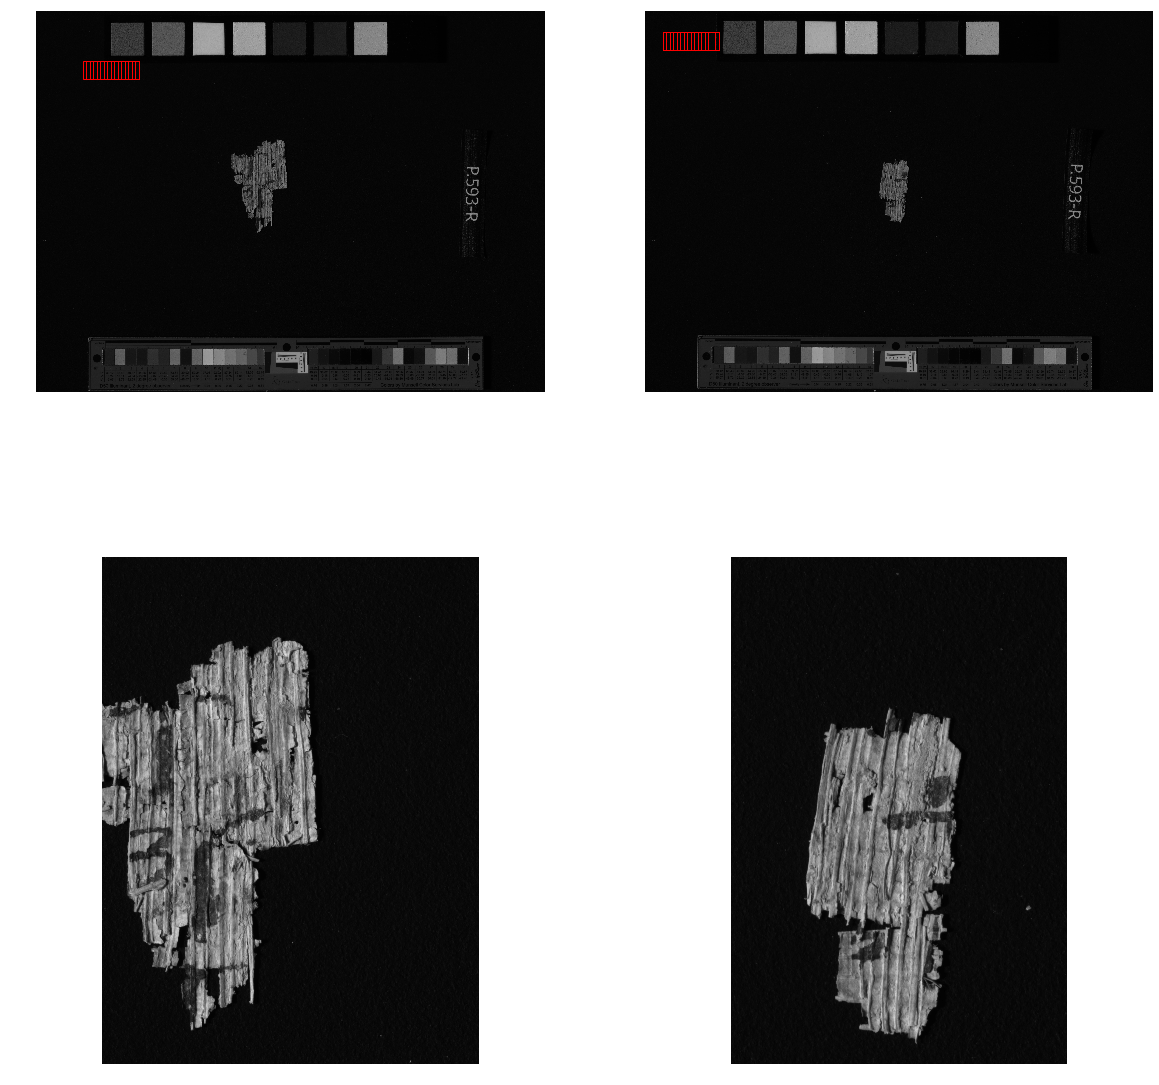

DONE P593Fg002


In [7]:
widgets.interact(view_image, item=matches)